In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

1.3.0 1.17.3


In [19]:
# Experiment configuration
experiment_name = "dpf_all_sensors_tbtt4"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [20]:
# Create models & training buddy

pf_model = panda_models.PandaParticleFilterNetwork()

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"]
)

[buddy-dpf_all_sensors_tbtt4] Using device: cpu
[buddy-dpf_all_sensors_tbtt4] No checkpoint found


# Dynamics Model Pre-Training

In [21]:
# dynamics_trainset = panda_datasets.PandaDynamicsDataset(
#     "data/pull-test.hdf5",
#     "data/push-test.hdf5",
#     **dataset_args
# )

In [22]:
# dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=256, shuffle=True, num_workers=2)

# for i in range(0):
#     print("Training epoch", i)
#     panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=10)
#     print()


# Measurement Model Pre-Training

In [23]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/pushset_medium.hdf5",
    samples_per_pair=10,
    **dataset_args
)

Widget Javascript not detected.  It may not be installed or enabled properly.



Loaded 40000 points


In [ ]:
measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=16)
for i in range(15):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=256, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()



Training epoch 0


Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
buddy.save_checkpoint(label="before_e2e_training")

# End-to-end Training

In [ ]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/pushset_medium.hdf5",
    subsequence_length=4,
    particle_count=30,
    particle_variances=(.0005, .0005),
    **dataset_args
)

In [ ]:
##### Train end-to-end
pf_model.dynamics_model.state_noise = (0.005, 0.005)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=64, shuffle=True, num_workers=2)
for i in range(20):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

In [ ]:
buddy.save_checkpoint()

# Model eval

In [9]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/pushset_small.hdf5",
    **dataset_args
)

### Final Model

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



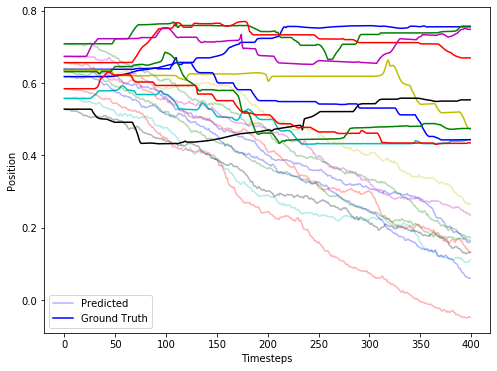

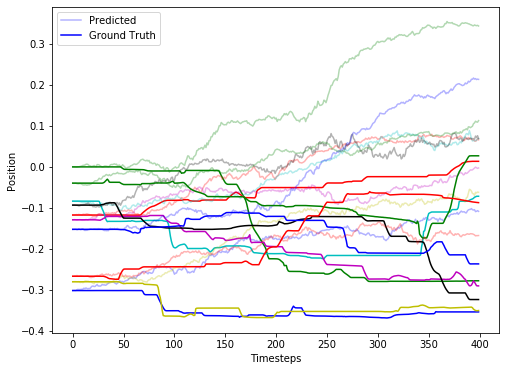

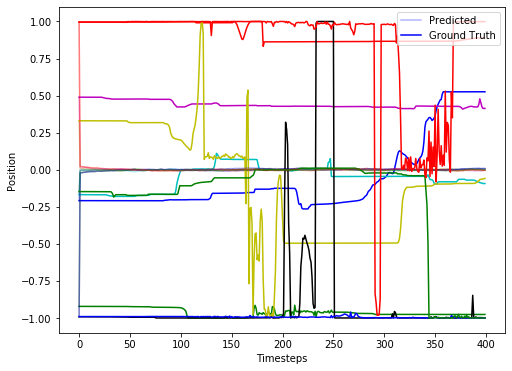

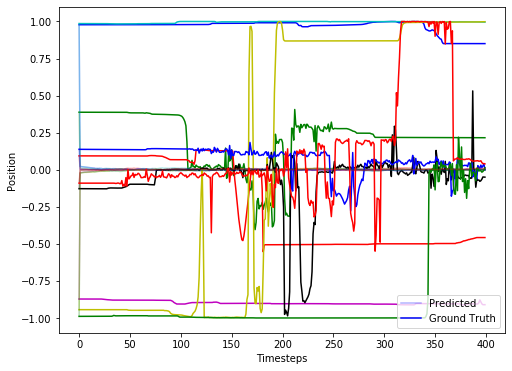

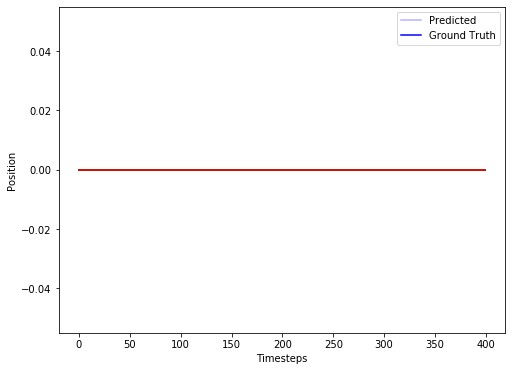

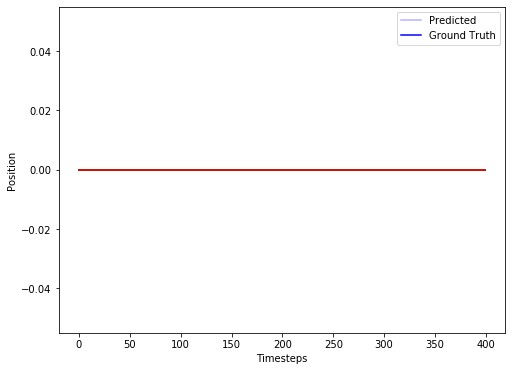

X RMSE:  0.2617968113931643
Y RMSE:  0.19611050541627467
(0.005, 0.005)


In [10]:
pf_model.dynamics_model.state_noise = (0.05, 0.05)
pf_model.dynamics_model.state_noise = (0.005, 0.005)

pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise)

### Model without end-to-end training

In [ ]:
pf_model.dynamics_model.state_noise = (0.005, 0.005)


# Back up model
buddy.save_checkpoint()

# Load the pre-end-to-end-training version of the model & evaluate
buddy.load_checkpoint(label="before_e2e_training")

pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)

# Restore model
buddy.load_checkpoint()